In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from qiskit import QuantumCircuit
from qiskit.result import ProbDistribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime.fake_provider import FakeValenciaV2
from qiskit_ibm_runtime import SamplerV2

import mthree

import matplotlib.pyplot as plt

from utils import export_data_json, generate_output_dir, generate_full_file_path

In [2]:
OUTPUT_PATH = os.path.join(os.getcwd(), 'm3-tests')
generate_output_dir(OUTPUT_PATH)

/home/alexandre/projects/scientific-research-2-qec-and-qem/src/m3-tests already exists!


In [3]:
fake_backend = FakeValenciaV2()
backend = AerSimulator.from_backend(fake_backend)

In [4]:
sampler = SamplerV2(backend=backend)

In [5]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

In [6]:
N_QUBITS = 5

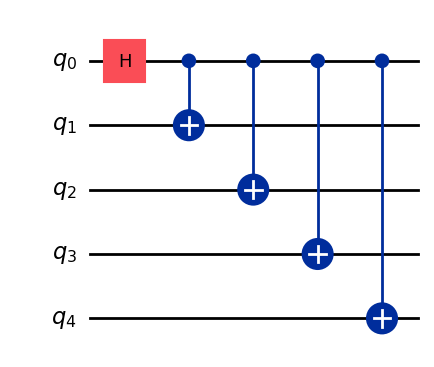

Default Circuit DEPTH: 5


In [7]:
qc = QuantumCircuit(N_QUBITS)
qc.h(0)
for i in range(1,N_QUBITS):
    qc.cx(0, i)
display(qc.draw('mpl', filename=generate_full_file_path(OUTPUT_PATH, "GHZ-circuit.png")))
print(f"Default Circuit DEPTH: {qc.depth()}")

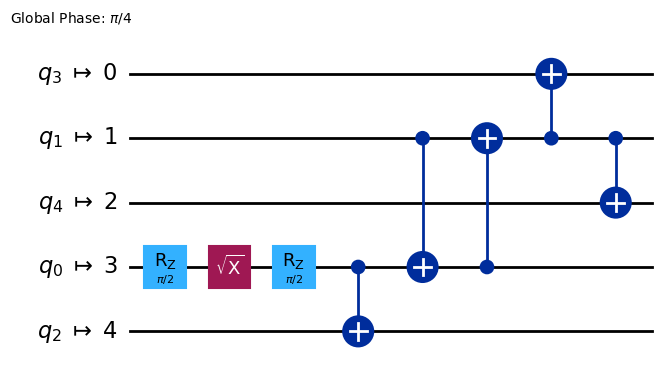

ISA Circuit DEPTH: 8


In [8]:
isa_circuit = pm.run(qc)
display(isa_circuit.draw('mpl', idle_wires=False, filename=generate_full_file_path(OUTPUT_PATH, "ISA-GHZ-circuit.png")))
print(f"ISA Circuit DEPTH: {isa_circuit.depth()}")

In [9]:
SHOTS = 1000

In [10]:
isa_circuit_cp = isa_circuit.copy()
isa_circuit_cp.measure_all()
results = sampler.run([isa_circuit_cp], shots=SHOTS).result()[0]

In [11]:
counts = results.data.meas.get_counts()
export_data_json(counts, generate_full_file_path(OUTPUT_PATH, "noisy-outputs.json"))

saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/m3-tests/noisy-outputs.json...


In [12]:
quasi = ProbDistribution(counts).binary_probabilities(num_bits=N_QUBITS)
export_data_json(counts, generate_full_file_path(OUTPUT_PATH, "noisy-outputs-quasi-dist.json"))

saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/m3-tests/noisy-outputs-quasi-dist.json...


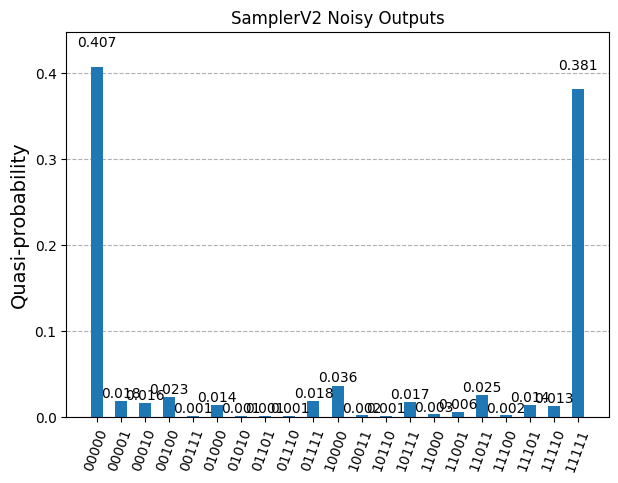

In [13]:
fig = plot_distribution(quasi, title="SamplerV2 Noisy Outputs")
fig.savefig(generate_full_file_path(OUTPUT_PATH, "sampler-noisy-ouputs.png"))
display(fig)

In [14]:
m3 = mthree.M3Mitigation(backend)
qubits = list(range(N_QUBITS))
m3.cals_from_system(qubits, SHOTS)
m3_quasi = m3.apply_correction(counts, qubits)
export_data_json(counts, generate_full_file_path(OUTPUT_PATH, "m3-dist.json"))

saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/m3-tests/m3-dist.json...


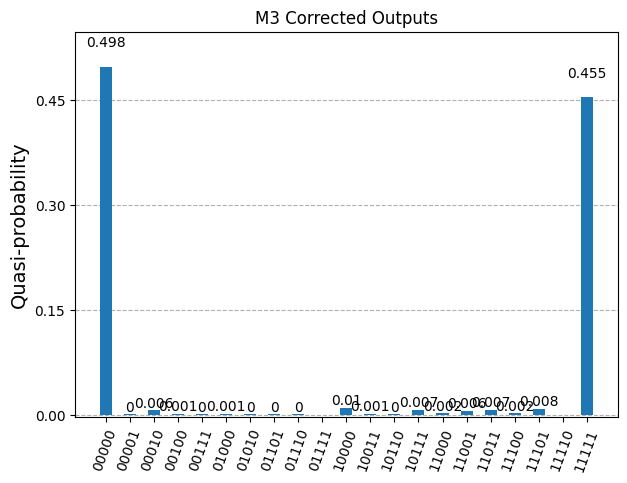

In [15]:
fig = plot_distribution(m3_quasi, title="M3 Corrected Outputs")
fig.savefig(generate_full_file_path(OUTPUT_PATH, "m3-ouputs.png"))
display(fig)